In [1]:
import pandas as pd
import torch
from transformers import Wav2Vec2FeatureExtractor, UniSpeechSatForXVector
from transformers import WavLMForXVector, Wav2Vec2ForSequenceClassification, Wav2Vec2ForXVector
import soundfile as sf
import os
import librosa
from collections import Counter
import sklearn
from sklearn.metrics import mean_absolute_error

In [2]:
torch.__version__

'2.5.1+cu124'

In [3]:
train = pd.read_csv("train.csv")

In [4]:
test = pd.read_csv("test.csv")

In [5]:
test.shape

(8602, 8)

<Axes: >

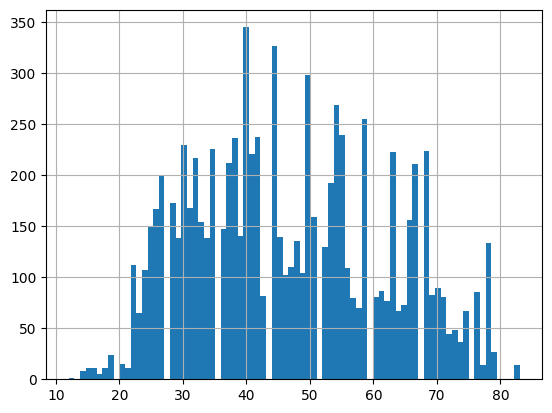

In [6]:
test.age.hist(bins=80)

<Axes: >

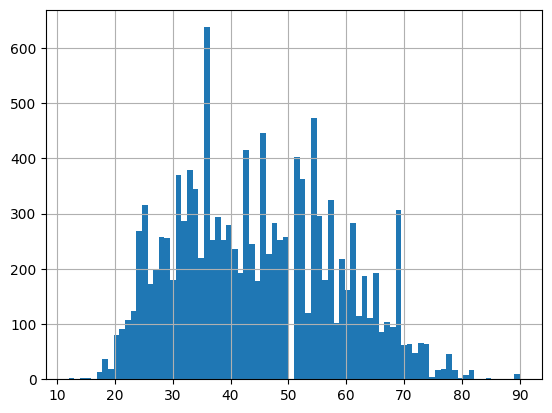

In [7]:
train.age.hist(bins=80)

In [8]:
def get_correct_recordings_index(spk_labels, compute_least_freq=True):
    print("get_correct_recordings_index >>>")
    print("compute least freq:", compute_least_freq)
    if compute_least_freq:
        spk_labels_dict = {i:spk_labels.count(i) for i in set(spk_labels)}
        least_freq_spk = min(list(spk_labels_dict.values()))
    else:
        least_freq_spk = 1
    print("Least freq:", least_freq_spk)
    speaker_indexes = []
    frequency_spk_labels_dict = {}
    for x in set(spk_labels):
        frequency_spk_labels_dict[x] = 0
    for index, spk_id in enumerate(spk_labels):
        frequency_spk_labels_dict[spk_id] += 1
        if frequency_spk_labels_dict[spk_id] > least_freq_spk:
            next
        else:
            speaker_indexes.append(index)
    print("get_correct_recordings_index <<<")
    return speaker_indexes



In [9]:
def extract_embeddings_wavlm(model_name, frame):
    frame_name = model_name.replace("/","_").replace("-","_")
    if os.path.isfile(frame_name):
        f1 = pd.read_pickle(frame_name)
        if f1.shape[0] == frame.shape[0]:
            return frame_name
        else:
            print("extracting ",model_name)
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
    if "hubert" in model_name:
        model_type="hubert"
        
    if "unispeech" in model_name:
        model_type = "uni"
    if "wavlm" in model_name:
        model_type = "wavlm"
    if "wav2vec" in model_name:
        model_type = "wav2vec"
        
        
    if model_type == "wavlm":
        model = WavLMForXVector.from_pretrained(model_name)
    if model_type == "wav2vec":
        model = Wav2Vec2ForXVector.from_pretrained(model_name)
    if model_type == "uni":
        model = UniSpeechSatForXVector.from_pretrained(model_name)
    if model_type == "hubert":
        model = HubertForSequenceClassification.from_pretrained(model_name)
    model.cuda()  
    x=[]
    

    with torch.no_grad():
        for index, row in frame.iterrows():
            sig, sr = librosa.load(row.wav,sr=16000)
            inputs = feature_extractor(sig,sampling_rate=16000,return_tensors="pt",padding=True).to("cuda:0")
            embeddings = model(**inputs).embeddings
            
            embeddings.cpu().numpy()[0]
            x.append(embeddings[0].cpu())
            #y.append(row.age)
    x = np.array(x)
    print(x.shape, model_name)
    x = list(x)
    frame["emb"]=x
    frame.to_pickle(frame_name)
    return frame_name


In [10]:
models_to_test = ['anton-l/wav2vec2-base-superb-sv', 'microsoft/unispeech-sat-large-sv', "microsoft/unispeech-sat-base-plus-sv",
                 'microsoft/wavlm-base-plus-sv']


In [11]:
data=pd.concat([train,test])
data.sample(10)

,Unnamed: 0,voxID_video_id,VoxCeleb_ID,video_id,recording,path,subset,age
6548,6548,id00667-WgK-nU3JmEg-00259,id00667,WgK,nU3JmEg,/home/dorota/research/voxceleb2_joined/dev/aac...,train,58.0
1492,1492,id08280-BYgsK0dOz10-00012,id08280,BYgsK0dOz10,00012,/home/dorota/research/voxceleb2_joined/dev/aac...,train,50.0
4945,4945,id06370-oFZXf4D9MmI-00064,id06370,oFZXf4D9MmI,00064,/home/dorota/research/voxceleb2_joined/dev/aac...,test,50.0
5007,5007,id04787-m8DwVFfKjUw-00011,id04787,m8DwVFfKjUw,00011,/home/dorota/research/voxceleb2_joined/dev/aac...,test,24.0
3118,3118,id02945-D1iGHEIVn5U-00029,id02945,D1iGHEIVn5U,00029,/home/dorota/research/voxceleb2_joined/dev/aac...,test,55.0
4682,4682,id07916-djbn__rAJR4-00193,id07916,djbn__rAJR4,00193,/home/dorota/research/voxceleb2_joined/dev/aac...,train,38.0
2083,2083,id06478-tz-yDZnS0Dg-00333,id06478,tz,yDZnS0Dg,/home/dorota/research/voxceleb2_joined/dev/aac...,train,58.0
9729,9729,id06066-0Typv1cuS84-00006,id06066,0Typv1cuS84,00006,/home/dorota/research/voxceleb2_joined/dev/aac...,train,25.0
572,572,id02349-JlEn6wHPqkE-00092,id02349,JlEn6wHPqkE,00092,/home/dorota/research/voxceleb2_joined/dev/aac...,test,48.0
7070,7070,id05522-89vPVLfqz0I-00021,id05522,89vPVLfqz0I,00021,/home/dorota/research/voxceleb2_joined/dev/aac...,test,37.0


In [12]:
data.path.values[0]

'/home/dorota/research/voxceleb2_joined/dev/aac/id08110/jpyddhVD_os/00157.m4a'

In [13]:
# to get wav instead m4a run ./convert.sh and then following command:

data["wav"]=data.path.replace("m4a","wav")

In [14]:
# backup data is saved after this step 
for model in models_to_test:
    framep = extract_embeddings_wavlm(model,data)

In [15]:
def get_arr_from_frame(frame):
    x = [list(i) for i in frame.emb.values]
    x = np.array(x)
    return x

In [16]:
def score(xtrain,ytrain,xtest,ytest,embedding):

    r=[]
    mdls = []
    for m in ['ridge', 'lm', 'lasso']:
            mdl=m
            strategy=''
            n_bin=None
            overlap=None
            age=None
            import time
            timestr = time.strftime("%Y%m%d-%H%M%S")
            config = {
                'seed' : 19951008,
                'log_interval' : 1,
                'model_name' : mdl,
                'feature_norm' : strategy,
                'num_bins': n_bin,
                'overlap_bin': overlap,
                'age_overlap': age,
                'dropout': None,
                'dataset' : 'age',
                'embedding' :embedding,
                'folder_fn': 'xvectors/lin_reg/',
                'unbalanced': False,
                'timestamp': timestr,
                "final_train_eval": True

            }

            model=final_eval(xtrain, ytrain, strategy, mdl)
            print("x test shape",xtest.shape, "y_test", len(ytest))
            y_pred = model.predict(xtest)
            test_mae = sklearn.metrics.mean_absolute_error(y_pred=y_pred, y_true=ytest)
            mae_per_obs = np.abs(y_pred - ytest)
            std_mae = np.std(mae_per_obs)
            print(model, test_mae, mae_per_obs, std_mae)
            print("model, unbalanced, test_mae, mae_per_obs, std_mae")
            d={}
            d["model"]=mdl
            d["embedding"]=embedding
            d["unbalanced"]=False
            d["test_mae"]=test_mae
            d["mae_per_obs"]=mae_per_obs
            d["std_mae"]=std_mae
            r.append(d)
            mdls.append(model)
            
    return pd.DataFrame(r)


In [17]:
def final_eval(X_train, y_train, preprocessing_strategy, model_name):
    X_train = torch.tensor(X_train)
    X_train = X_train.cuda()
    """
    #kfold = sklearn.model_selection.KFold(n_splits=k, shuffle=True, random_state=config['seed'])
    unique_labels = list(set(spk_labels))
    unique_labels = np.array(unique_labels)

    
    train_labels = unique_labels
    
    if unbalanced:
        idx_train = [i for i, x in enumerate(spk_labels) if x in train_labels] 
    else:
        idx_train = train_index
    """
    train_embeddings = X_train
    
    if preprocessing_strategy == 'cwl':
        
        vector_processor = VectorProcessor.train(X_train, 'cwl', 'cuda:0')
        train_embeddings = vector_processor.process(X_train)
    elif preprocessing_strategy == 'wccn':
        L = wccn(X_train.cpu().numpy(), y_train, 0, num_bins=config['num_bins'])
        train_embeddings = torch.matmul(X_train, torch.from_numpy(L).cuda().float())
    elif preprocessing_strategy == 'pca':
        from sklearn.decomposition import PCA
        pca = PCA(n_components=int(X_train.shape[1]/2))
        train_embeddings = pca.fit_transform(X_train.cpu().numpy())


    if preprocessing_strategy != 'pca':
        train_embeddings = train_embeddings.cpu().numpy()
    if model_name == 'lm':
        model = sklearn.linear_model.LinearRegression().fit(train_embeddings, y_train)
    elif model_name == 'lasso':
        model = sklearn.linear_model.LassoCV(
            max_iter=50000,
            tol=0.005,
            n_jobs=-1).fit(train_embeddings, y_train)
    elif model_name == 'ridge':
        model = sklearn.linear_model.RidgeCV().fit(train_embeddings, y_train)
    elif model_name == 'svr_rbf':
        model = sklearn.svm.SVR().fit(train_embeddings, y_train)
    elif model_name == 'svr_poly':
        model = sklearn.svm.SVR(kernel='poly').fit(train_embeddings, y_train)
    elif model_name == 'svr_lin':
        model = sklearn.svm.SVR(kernel='linear').fit(train_embeddings, y_train)
    elif model_name == 'svr_sigm':
        model = sklearn.svm.SVR(kernel='sigmoid').fit(train_embeddings, y_train)
    y_pred = model.predict(train_embeddings)
    train_mae = sklearn.metrics.mean_absolute_error(y_pred=y_pred, y_true=y_train)
    mae_per_obs = np.abs(y_pred - y_train)
    std_mae = np.std(mae_per_obs)
    print(
        {
            'Train MAE': train_mae,
            'Scenario': 'test_mode',
            'train_std_mae': std_mae,
            'train shape':train_embeddings.shape,
            

        }
    )
    return model


# training explanation with wav2vec model

In [18]:
model_name='anton-l/wav2vec2-base-superb-sv'
frame_name = model_name.replace("/","_").replace("-","_")
traintest = pd.read_pickle(frame_name)

train = traintest[traintest.subset=="train"]
test = traintest[traintest.subset=="test"]

In [19]:
train.shape, test.shape

((12722, 9), (8602, 9))

In [20]:
# 512 values for each wav file are stored in frame
train.emb.values[0][:10], train.emb.values[0].shape

(array([-0.06548898, -0.08250634, -0.08518874,  0.18258429,  0.18643337,
        -0.25863564, -0.10542293,  0.115172  , -0.4003692 , -0.09974505],
       dtype=float32),
 (512,))

In [21]:
xtrain = get_arr_from_frame(train)
ytrain = train.age.values

xtest = get_arr_from_frame(test)
ytest = test.age.values


In [22]:
xtrain.shape, xtest.shape

((12722, 512), (8602, 512))

In [23]:
idx_train_balanced = get_correct_recordings_index(list(train.plda_vox_yt_id.values))
idx_test_balanced = get_correct_recordings_index(list(test.plda_vox_yt_id.values), compute_least_freq=True)

get_correct_recordings_index >>>
compute least freq: True
Least freq: 1
get_correct_recordings_index <<<
get_correct_recordings_index >>>
compute least freq: True
Least freq: 1
get_correct_recordings_index <<<


In [24]:
len(idx_train_balanced), len(idx_test_balanced)

(1690, 1127)

In [25]:
test_idx = [i for i in range(test.shape[0])]
test_idx_balanced = [True if i in idx_test_balanced else False for i in test_idx]
test_balanced = test[test_idx_balanced]

train_idx = [i for i in range(train.shape[0])]
train_idx_balanced = [True if i in idx_train_balanced else False for i in train_idx]
train_balanced = train[train_idx_balanced]

In [26]:
Counter(train_balanced.VoxCeleb_ID).most_common(10)

[('id08110', 1),
 ('id02273', 1),
 ('id08699', 1),
 ('id09049', 1),
 ('id01617', 1),
 ('id04309', 1),
 ('id01528', 1),
 ('id03059', 1),
 ('id06250', 1),
 ('id07360', 1)]

In [27]:
Counter(train.VoxCeleb_ID).most_common(10)

[('id00524', 196),
 ('id05171', 173),
 ('id09049', 137),
 ('id06645', 105),
 ('id06823', 101),
 ('id07376', 98),
 ('id06676', 96),
 ('id07108', 77),
 ('id06724', 76),
 ('id08629', 71)]

In [28]:
# in balanced training and testing only one file for each VoxCeleb_ID is used

In [29]:
len(set(train.VoxCeleb_ID)), train_balanced.shape

(1690, (1690, 9))

In [30]:
len(set(test_balanced.VoxCeleb_ID)), test_balanced.shape

(1127, (1127, 9))

In [31]:
# in unbalanced training/testing all files from each VoxCeleb_ID is used

In [32]:
len(set(train.VoxCeleb_ID)), train.shape

(1690, (12722, 9))

In [33]:
len(set(test.VoxCeleb_ID)), test.shape

(1127, (8602, 9))

In [34]:
# unbalanced_test and unbalanced train
f1=score(xtrain,ytrain,xtest,ytest,"unb_traintest_"+frame_name)

{'Train MAE': 7.281521084423954, 'Scenario': 'test_mode', 'train_std_mae': np.float64(5.767090136507422), 'train shape': (12722, 512)}
x test shape (8602, 512) y_test 8602
RidgeCV() 8.381581341311099 [ 8.05408654  5.38622527 26.03158732 ...  0.79868411 17.52838171
  6.62531492] 6.5840345428382445
model, unbalanced, test_mae, mae_per_obs, std_mae
{'Train MAE': 7.242042359194841, 'Scenario': 'test_mode', 'train_std_mae': np.float64(5.7520122011048835), 'train shape': (12722, 512)}
x test shape (8602, 512) y_test 8602
LinearRegression() 8.488730343461896 [ 8.00684357  2.19124603 27.50402832 ...  0.32041168 17.53099823
  6.89304733] 6.652267415207931
model, unbalanced, test_mae, mae_per_obs, std_mae
{'Train MAE': 7.605873444792123, 'Scenario': 'test_mode', 'train_std_mae': np.float64(5.936284033616649), 'train shape': (12722, 512)}
x test shape (8602, 512) y_test 8602
LassoCV(max_iter=50000, n_jobs=-1, tol=0.005) 8.403824680490677 [ 9.52429962  8.36058044 27.71013641 ...  3.15529251 18.267

In [35]:
f1

,model,embedding,unbalanced,test_mae,mae_per_obs,std_mae
0,ridge,unb_traintest_anton_l_wav2vec2_base_superb_sv,False,8.381581,"[8.054086539426407, 5.386225266627157, 26.0315...",6.584035
1,lm,unb_traintest_anton_l_wav2vec2_base_superb_sv,False,8.488730,"[8.006843566894531, 2.1912460327148438, 27.504...",6.652267
2,lasso,unb_traintest_anton_l_wav2vec2_base_superb_sv,False,8.403825,"[9.524299621582031, 8.360580444335938, 27.7101...",6.601397


# train and test for all models

In [36]:
#computing all results for alll models:

res = []
for model_name in models_to_test:
    frame_name = model_name.replace("/","_").replace("-","_")
    traintest = pd.read_pickle(frame_name)
    train = traintest[traintest.subset=="train"]
    test = traintest[traintest.subset=="test"]
    
    xtrain = get_arr_from_frame(train)
    ytrain = train.age.values
    
    xtest = get_arr_from_frame(test)
    ytest = test.age.values
    
    idx_train_balanced = get_correct_recordings_index(list(train.plda_vox_yt_id.values))
    idx_test_balanced = get_correct_recordings_index(list(test.plda_vox_yt_id.values), compute_least_freq=True)

    
    test_idx = [i for i in range(test.shape[0])]
    test_idx_balanced = [True if i in idx_test_balanced else False for i in test_idx]
    test_balanced = test[test_idx_balanced]
    
    train_idx = [i for i in range(train.shape[0])]
    train_idx_balanced = [True if i in idx_train_balanced else False for i in train_idx]
    train_balanced = train[train_idx_balanced]
    
    xtrain_balanced = get_arr_from_frame(train_balanced)
    ytrain_balanced = train_balanced.age.values
    
    xtest_balanced = get_arr_from_frame(test_balanced)
    ytest_balanced = test_balanced.age.values
    
    # unbalanced_test
    f1=score(xtrain,ytrain,xtest,ytest,"unb_traintest_"+frame_name)
    
    # unbalanced train balanced test
    f2=score(xtrain,ytrain,xtest_balanced,ytest_balanced,"unb_train_bal_test_"+frame_name)
    
    # balanced train and test
    f3=score(xtrain_balanced,ytrain_balanced,xtest_balanced,ytest_balanced,"bal_train_bal_test_"+frame_name)
    
    
    # balanced train and unbalanced_test
    f4=score(xtrain_balanced,ytrain_balanced,xtest,ytest,"bal_train_unb_test_"+frame_name)
    
    res.append(f1)
    res.append(f2)
    res.append(f3)
    res.append(f4)
    print(train_balanced.shape)
    
    

get_correct_recordings_index >>>
compute least freq: True
Least freq: 1
get_correct_recordings_index <<<
get_correct_recordings_index >>>
compute least freq: True
Least freq: 1
get_correct_recordings_index <<<
{'Train MAE': 7.281521084423954, 'Scenario': 'test_mode', 'train_std_mae': np.float64(5.767090136507422), 'train shape': (12722, 512)}
x test shape (8602, 512) y_test 8602
RidgeCV() 8.381581341311099 [ 8.05408654  5.38622527 26.03158732 ...  0.79868411 17.52838171
  6.62531492] 6.5840345428382445
model, unbalanced, test_mae, mae_per_obs, std_mae
{'Train MAE': 7.242042359194841, 'Scenario': 'test_mode', 'train_std_mae': np.float64(5.7520122011048835), 'train shape': (12722, 512)}
x test shape (8602, 512) y_test 8602
LinearRegression() 8.488730343461896 [ 8.00684357  2.19124603 27.50402832 ...  0.32041168 17.53099823
  6.89304733] 6.652267415207931
model, unbalanced, test_mae, mae_per_obs, std_mae
{'Train MAE': 7.605873444792123, 'Scenario': 'test_mode', 'train_std_mae': np.float64

{'Train MAE': 9.321104571099818, 'Scenario': 'test_mode', 'train_std_mae': np.float64(6.9286827984429005), 'train shape': (1690, 512)}
x test shape (8602, 512) y_test 8602
LassoCV(max_iter=50000, n_jobs=-1, tol=0.005) 10.507760849921434 [20.07342911 25.11680603 28.7896347  ...  1.56998444 14.80997086
  6.38957977] 7.747988168616415
model, unbalanced, test_mae, mae_per_obs, std_mae
(1690, 9)
get_correct_recordings_index >>>
compute least freq: True
Least freq: 1
get_correct_recordings_index <<<
get_correct_recordings_index >>>
compute least freq: True
Least freq: 1
get_correct_recordings_index <<<
{'Train MAE': 6.466939616907259, 'Scenario': 'test_mode', 'train_std_mae': np.float64(5.288409889655587), 'train shape': (12722, 512)}
x test shape (8602, 512) y_test 8602
RidgeCV() 7.485059461007343 [ 1.64247435 10.61744247 11.77658244 ...  0.10216917 10.43420943
  3.2739409 ] 5.877048506698091
model, unbalanced, test_mae, mae_per_obs, std_mae
{'Train MAE': 6.5393911542204295, 'Scenario': 'te

{'Train MAE': 7.307328601519762, 'Scenario': 'test_mode', 'train_std_mae': np.float64(5.745011967990429), 'train shape': (1690, 512)}
x test shape (8602, 512) y_test 8602
RidgeCV() 7.300237393972984 [ 6.53808128 14.40163991 12.48461947 ...  0.49186348 14.21834779
  4.55078527] 5.793419221485036
model, unbalanced, test_mae, mae_per_obs, std_mae
{'Train MAE': 6.08803641979511, 'Scenario': 'test_mode', 'train_std_mae': np.float64(4.804971560548781), 'train shape': (1690, 512)}
x test shape (8602, 512) y_test 8602
LinearRegression() 8.144984997862634 [ 5.45213318 11.84413147  0.67750549 ...  2.21371078 12.11788177
  8.03520966] 6.4241469377853
model, unbalanced, test_mae, mae_per_obs, std_mae
{'Train MAE': 7.4341514519685825, 'Scenario': 'test_mode', 'train_std_mae': np.float64(5.8301600454327005), 'train shape': (1690, 512)}
x test shape (8602, 512) y_test 8602
LassoCV(max_iter=50000, n_jobs=-1, tol=0.005) 7.393025569875859 [ 8.05079269 14.65590668 12.44911194 ...  1.55106354 15.36630249


In [37]:
results = pd.concat(res).sort_values(by=["embedding","test_mae"])
results

,model,embedding,unbalanced,test_mae,mae_per_obs,std_mae
0,ridge,bal_train_bal_test_anton_l_wav2vec2_base_super...,False,8.868182,"[14.230262056606293, 7.402694203868251, 24.765...",6.782028
2,lasso,bal_train_bal_test_anton_l_wav2vec2_base_super...,False,8.944041,"[16.230796813964844, 10.117496490478516, 24.39...",6.805978
1,lm,bal_train_bal_test_anton_l_wav2vec2_base_super...,False,10.477716,"[4.160865783691406, 0.5954513549804688, 20.140...",8.095245
0,ridge,bal_train_bal_test_microsoft_unispeech_sat_bas...,False,7.892862,"[4.055204502962354, 2.255488309701761, 15.0395...",6.206020
2,lasso,bal_train_bal_test_microsoft_unispeech_sat_bas...,False,7.975923,"[6.402412414550781, 2.5568923950195312, 14.067...",6.279735
1,lm,bal_train_bal_test_microsoft_unispeech_sat_bas...,False,9.444683,"[3.4896011352539062, 16.670509338378906, 19.62...",7.212078
0,ridge,bal_train_bal_test_microsoft_unispeech_sat_lar...,False,10.430774,"[18.495159812420738, 22.836636990136604, 30.27...",7.199508
2,lasso,bal_train_bal_test_microsoft_unispeech_sat_lar...,False,10.464692,"[20.073429107666016, 25.116806030273438, 28.78...",7.189858
1,lm,bal_train_bal_test_microsoft_unispeech_sat_lar...,False,11.534018,"[29.809539794921875, 34.845855712890625, 30.01...",8.539396
0,ridge,bal_train_bal_test_microsoft_wavlm_base_plus_sv,False,7.700779,"[6.538081278578346, 14.40163991305321, 12.4846...",5.995905


In [38]:
results[results.embedding.str.startswith("unb_traintest_")]

,model,embedding,unbalanced,test_mae,mae_per_obs,std_mae
0,ridge,unb_traintest_anton_l_wav2vec2_base_superb_sv,False,8.381581,"[8.054086539426407, 5.386225266627157, 26.0315...",6.584035
2,lasso,unb_traintest_anton_l_wav2vec2_base_superb_sv,False,8.403825,"[9.524299621582031, 8.360580444335938, 27.7101...",6.601397
1,lm,unb_traintest_anton_l_wav2vec2_base_superb_sv,False,8.488730,"[8.006843566894531, 2.1912460327148438, 27.504...",6.652267
0,ridge,unb_traintest_microsoft_unispeech_sat_base_plu...,False,7.485059,"[1.6424743511561246, 10.617442470860368, 11.77...",5.877049
2,lasso,unb_traintest_microsoft_unispeech_sat_base_plu...,False,7.496366,"[0.6132583618164062, 5.389656066894531, 14.180...",5.885239
1,lm,unb_traintest_microsoft_unispeech_sat_base_plu...,False,7.538754,"[4.107784271240234, 8.317626953125, 11.3747253...",5.884892
2,lasso,unb_traintest_microsoft_unispeech_sat_large_sv,False,10.055522,"[20.560821533203125, 26.24176788330078, 23.061...",7.462882
0,ridge,unb_traintest_microsoft_unispeech_sat_large_sv,False,10.098043,"[19.763295505138146, 27.974488904760562, 23.13...",7.547424
1,lm,unb_traintest_microsoft_unispeech_sat_large_sv,False,10.155836,"[19.14630889892578, 28.38058090209961, 22.9752...",7.596011
2,lasso,unb_traintest_microsoft_wavlm_base_plus_sv,False,7.253769,"[1.2071380615234375, 8.525627136230469, 12.701...",5.707341


In [39]:
results[results.embedding.str.startswith("bal_train_bal_test_")]

,model,embedding,unbalanced,test_mae,mae_per_obs,std_mae
0,ridge,bal_train_bal_test_anton_l_wav2vec2_base_super...,False,8.868182,"[14.230262056606293, 7.402694203868251, 24.765...",6.782028
2,lasso,bal_train_bal_test_anton_l_wav2vec2_base_super...,False,8.944041,"[16.230796813964844, 10.117496490478516, 24.39...",6.805978
1,lm,bal_train_bal_test_anton_l_wav2vec2_base_super...,False,10.477716,"[4.160865783691406, 0.5954513549804688, 20.140...",8.095245
0,ridge,bal_train_bal_test_microsoft_unispeech_sat_bas...,False,7.892862,"[4.055204502962354, 2.255488309701761, 15.0395...",6.206020
2,lasso,bal_train_bal_test_microsoft_unispeech_sat_bas...,False,7.975923,"[6.402412414550781, 2.5568923950195312, 14.067...",6.279735
1,lm,bal_train_bal_test_microsoft_unispeech_sat_bas...,False,9.444683,"[3.4896011352539062, 16.670509338378906, 19.62...",7.212078
0,ridge,bal_train_bal_test_microsoft_unispeech_sat_lar...,False,10.430774,"[18.495159812420738, 22.836636990136604, 30.27...",7.199508
2,lasso,bal_train_bal_test_microsoft_unispeech_sat_lar...,False,10.464692,"[20.073429107666016, 25.116806030273438, 28.78...",7.189858
1,lm,bal_train_bal_test_microsoft_unispeech_sat_lar...,False,11.534018,"[29.809539794921875, 34.845855712890625, 30.01...",8.539396
0,ridge,bal_train_bal_test_microsoft_wavlm_base_plus_sv,False,7.700779,"[6.538081278578346, 14.40163991305321, 12.4846...",5.995905


In [40]:
results[results.embedding.str.startswith("unb_train_bal_test_")]

,model,embedding,unbalanced,test_mae,mae_per_obs,std_mae
2,lasso,unb_train_bal_test_anton_l_wav2vec2_base_super...,False,8.804690,"[9.524299621582031, 8.360580444335938, 27.7101...",6.743241
0,ridge,unb_train_bal_test_anton_l_wav2vec2_base_super...,False,8.829863,"[8.054086539426407, 5.386225266627157, 26.0315...",6.757600
1,lm,unb_train_bal_test_anton_l_wav2vec2_base_super...,False,8.952706,"[8.006843566894531, 2.1912460327148438, 27.504...",6.905477
2,lasso,unb_train_bal_test_microsoft_unispeech_sat_bas...,False,8.048725,"[0.6132583618164062, 5.389656066894531, 14.180...",6.140063
0,ridge,unb_train_bal_test_microsoft_unispeech_sat_bas...,False,8.057842,"[1.6424743511561246, 10.617442470860368, 11.77...",6.203483
1,lm,unb_train_bal_test_microsoft_unispeech_sat_bas...,False,8.117951,"[4.107784271240234, 8.317626953125, 11.3747253...",6.226041
2,lasso,unb_train_bal_test_microsoft_unispeech_sat_lar...,False,10.417012,"[20.560821533203125, 26.24176788330078, 23.061...",7.195390
0,ridge,unb_train_bal_test_microsoft_unispeech_sat_lar...,False,10.474627,"[19.763295505138146, 27.974488904760562, 23.13...",7.440689
1,lm,unb_train_bal_test_microsoft_unispeech_sat_lar...,False,10.533392,"[19.14630889892578, 28.38058090209961, 22.9752...",7.519093
0,ridge,unb_train_bal_test_microsoft_wavlm_base_plus_sv,False,7.864408,"[0.3094190753684529, 5.227791050019491, 8.6506...",6.074968


# MAE variation

In [41]:
best_model_name = 'microsoft/wavlm-base-plus-sv'
xtrain = get_arr_from_frame(train)
ytrain = train.age.values
xtest = get_arr_from_frame(test)
ytest = test.age.values
model = final_eval(xtrain, ytrain , preprocessing_strategy="none", model_name="lasso")


{'Train MAE': 6.523982218649567, 'Scenario': 'test_mode', 'train_std_mae': np.float64(5.366244471152384), 'train shape': (12722, 512)}


In [42]:
model

LassoCV(max_iter=50000, n_jobs=-1, tol=0.005)

In [43]:

predicts = model.predict(xtest)

# extracting error for each test case
mae_ = []
for i in range(len(ytest)):
    mae_.append(mean_absolute_error([predicts[i]],[ytest[i]]))
    


d={}
for age,m in zip(test.age.values,mae_):
    if age not in d:
        d[age]=[]
    d[age].append(m)
    
# average mae for each age prediction
for i in d:
    d[i]=np.average(d[i])

x = []
y = []
for i in d:
    x.append(i)
    y.append(d[i])

In [44]:
import matplotlib.pyplot as plt
import numpy as np

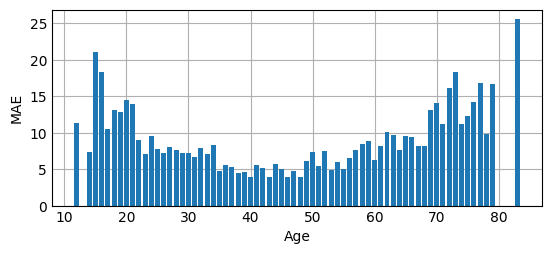

In [45]:


plt.style.use('_mpl-gallery')
plt.figure().set_figwidth(5)
plt.bar(x,y)
plt.xlabel('Age')
plt.ylabel('MAE')
plt.show()